## Import Library

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

In [ ]:
data_path='drive/My Drive/Copy of indonesia ai/Dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir(data_path)

['list_attribute.txt',
 'gender_classification.csv',
 'class_identity.txt',
 'Images',
 'gender_classification.gsheet',
 'model_saved']

In [ ]:
images_list = os.listdir(data_path+'/Images')

In [ ]:
# load the data
data = pd.read_csv(os.path.join(data_path, 'list_attribute.txt'), delimiter=r'\s+', skiprows=1, usecols = ['Male']).reset_index()# load data from file provided
data.rename(columns = {'index':'image_id'}, inplace = True)
data = data[data.image_id.isin(images_list)].reset_index(drop=True) # filter the data with available images only (5000 images)
data.replace(-1, 0, inplace=True)

In [ ]:
data

,image_id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


In [ ]:

category_count = data["Male"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    2953
1    2047
Name: Male, dtype: int64


In [ ]:
np.random.seed(42)
indices = data[data["Male"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
data = data.drop(drop_sample, axis = "index")
data["Male"].value_counts()

1    2047
0    2047
Name: Male, dtype: int64

In [ ]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify = data['Male'])

In [ ]:
test_data.Male.value_counts()

0    410
1    409
Name: Male, dtype: int64

## Preprocessing

In [ ]:
import cv2
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        # please define image convertion technique to RGB here
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(225),
        transforms.ColorJitter(brightness=0,contrast=0,saturation=0,hue=0),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.05),
        #transforms.RandomGrayscale(p=0.1),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)


In [ ]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"),
                          transform=transform
                          )
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
import numpy as np
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

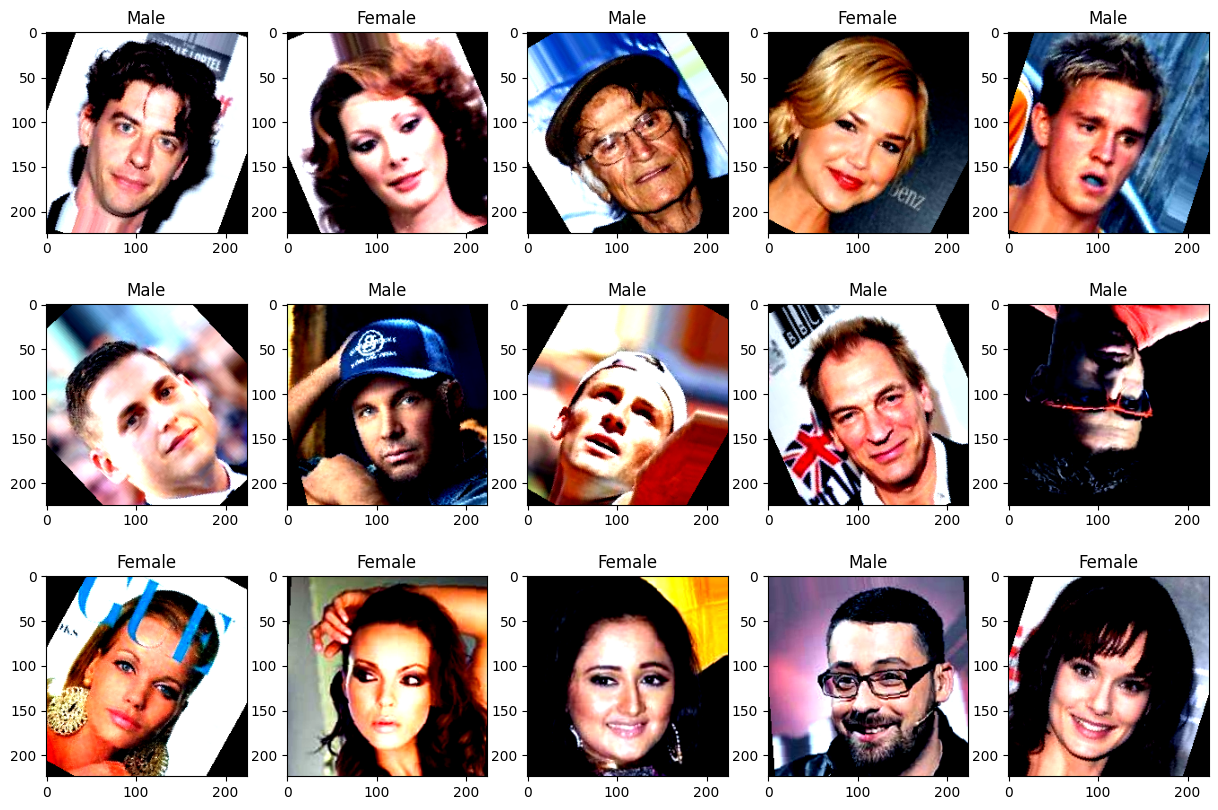

In [ ]:

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
Gender = {0: 'Female', 1: 'Male'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{Gender[label.item()]}") # add label

## Architecture

In [ ]:
# please define the model optimizer and criterion (loss function)
import torchvision.models as models
from torchsummary import summary

model = models.googlenet(init_weights=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
model.to('cuda');

## Modeling

## GoogleNet

In [ ]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    # please define the training model (VGG/GoogleNet/ResNet) here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)


                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            history.append([epoch+1, phase, epoch_loss, epoch_acc])

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./Bird/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
!mkdir Bird

In [ ]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}
use_gpu = torch.cuda.is_available()

model, history = train_model(model, dataloders, dataset_sizes, criterion, optimizer, use_gpu, 10)
model

Epoch 0/9
----------
train Loss: 0.0048 Acc: 0.9392
test Loss: 0.0058 Acc: 0.9304

Epoch 1/9
----------
train Loss: 0.0039 Acc: 0.9490
test Loss: 0.0061 Acc: 0.9328

Epoch 2/9
----------
train Loss: 0.0046 Acc: 0.9411
test Loss: 0.0067 Acc: 0.9158

Epoch 3/9
----------
train Loss: 0.0042 Acc: 0.9429
test Loss: 0.0063 Acc: 0.9206

Epoch 4/9
----------
train Loss: 0.0036 Acc: 0.9576
test Loss: 0.0060 Acc: 0.9219

Epoch 5/9
----------
train Loss: 0.0043 Acc: 0.9496
test Loss: 0.0050 Acc: 0.9475

Epoch 6/9
----------
train Loss: 0.0042 Acc: 0.9505
test Loss: 0.0048 Acc: 0.9390

Epoch 7/9
----------
train Loss: 0.0036 Acc: 0.9551
test Loss: 0.0086 Acc: 0.8999

Epoch 8/9
----------
train Loss: 0.0037 Acc: 0.9536
test Loss: 0.0054 Acc: 0.9390

Epoch 9/9
----------
train Loss: 0.0038 Acc: 0.9527
test Loss: 0.0060 Acc: 0.9316

Training complete in 5m 35s
Best test Acc: 0.947497


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
history_df = pd.DataFrame(history, columns= ["epoch", 'phase', 'epoch loss', 'epoch accuracy'])
train_history = history_df[history_df['phase'] == 'train']
test_history = history_df[history_df['phase'] == 'test']
history_df['epoch loss'] = history_df['epoch loss'].astype(float)
history_df['epoch accuracy'] = history_df['epoch accuracy'].astype(float)
history_df

,epoch,phase,epoch loss,epoch accuracy
0,1,train,0.004832,0.939237
1,1,test,0.005818,0.930403
2,2,train,0.003896,0.949008
3,2,test,0.006097,0.932845
4,3,train,0.004611,0.941069
5,3,test,0.006666,0.915751
6,4,train,0.004187,0.942901
7,4,test,0.006260,0.920635
8,5,train,0.003604,0.957557
9,5,test,0.006024,0.921856


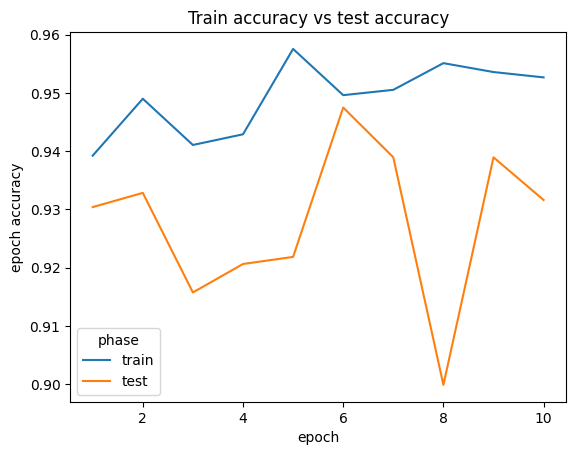

In [ ]:
import seaborn as sns
sns.lineplot(x='epoch', y='epoch accuracy', data=history_df, hue='phase')
plt.title("Train accuracy vs test accuracy")
plt.show()

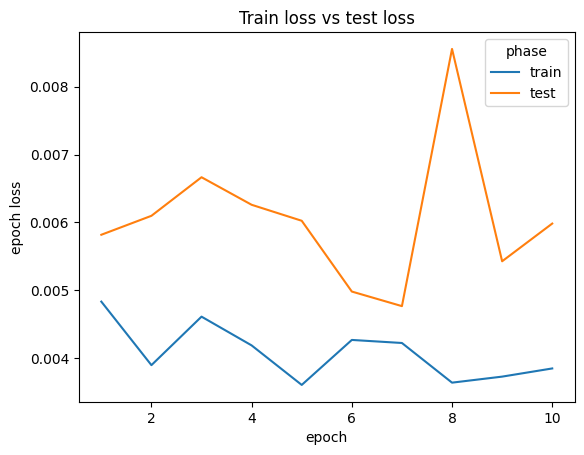

In [ ]:
import seaborn as sns
sns.lineplot(x='epoch', y='epoch loss', data=history_df, hue='phase')
plt.title("Train loss vs test loss")
plt.show()

## Evaluation

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Average Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(dataloders, model, criterion, use_gpu)

Average Test Loss: 0.178001


Test Accuracy: 93% (766/819)


In [ ]:
def evaluate_model(model, test_loader, target_labels, use_cuda):

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            inputs = inputs.cuda()
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('Female', 'Male')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

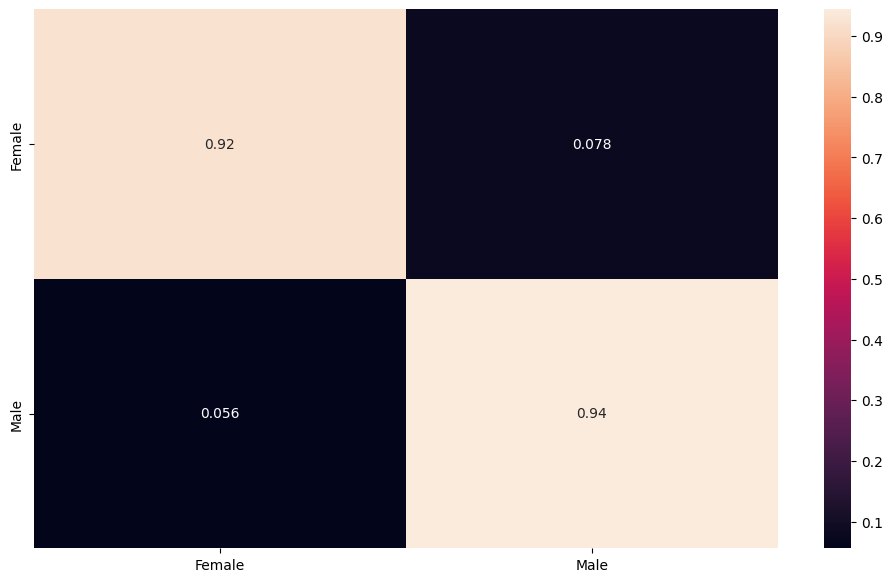

In [ ]:
evaluate_model(model, dataloders['test'], ["female", "male"], use_gpu)

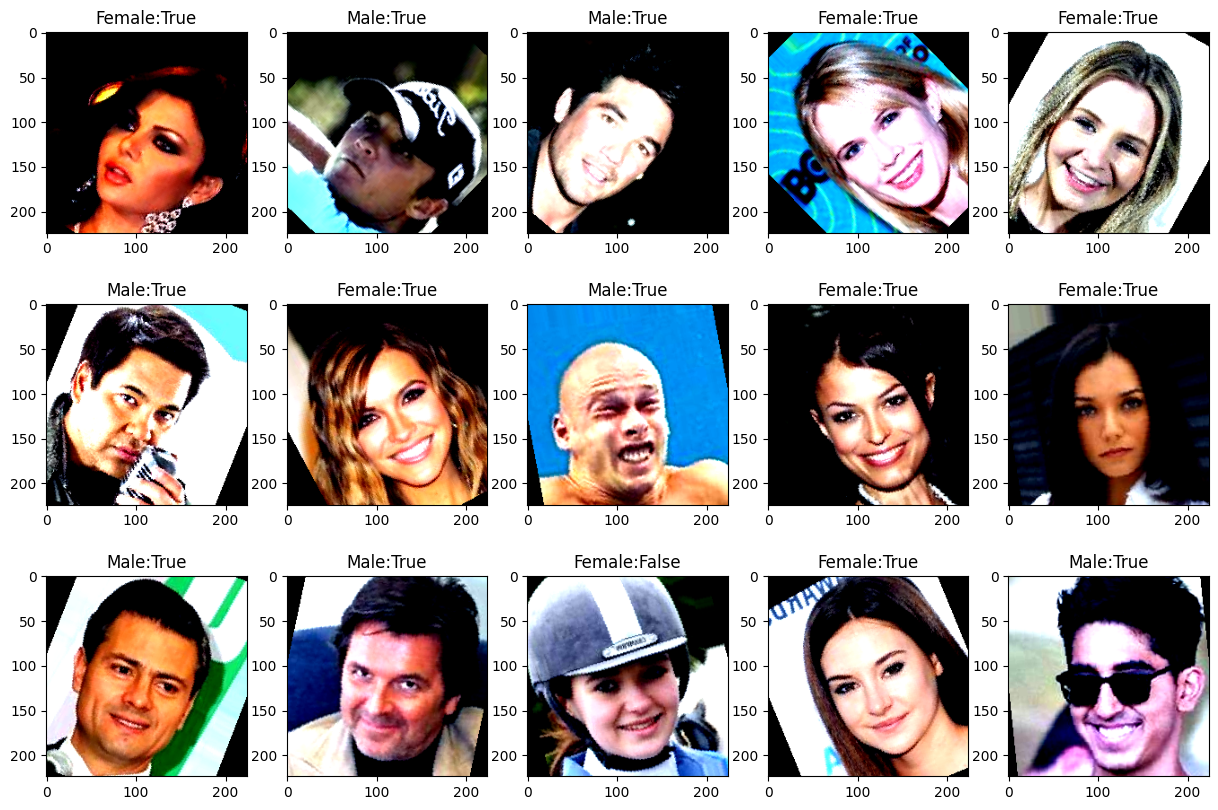

In [ ]:
dataiter = iter(dataloders['test'])
images, labels = next(dataiter)
classes = {0: 'Female', 1: 'Male'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor = image_tensor.cuda()
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(classes[label.item()])+":" +str(k)) # add label

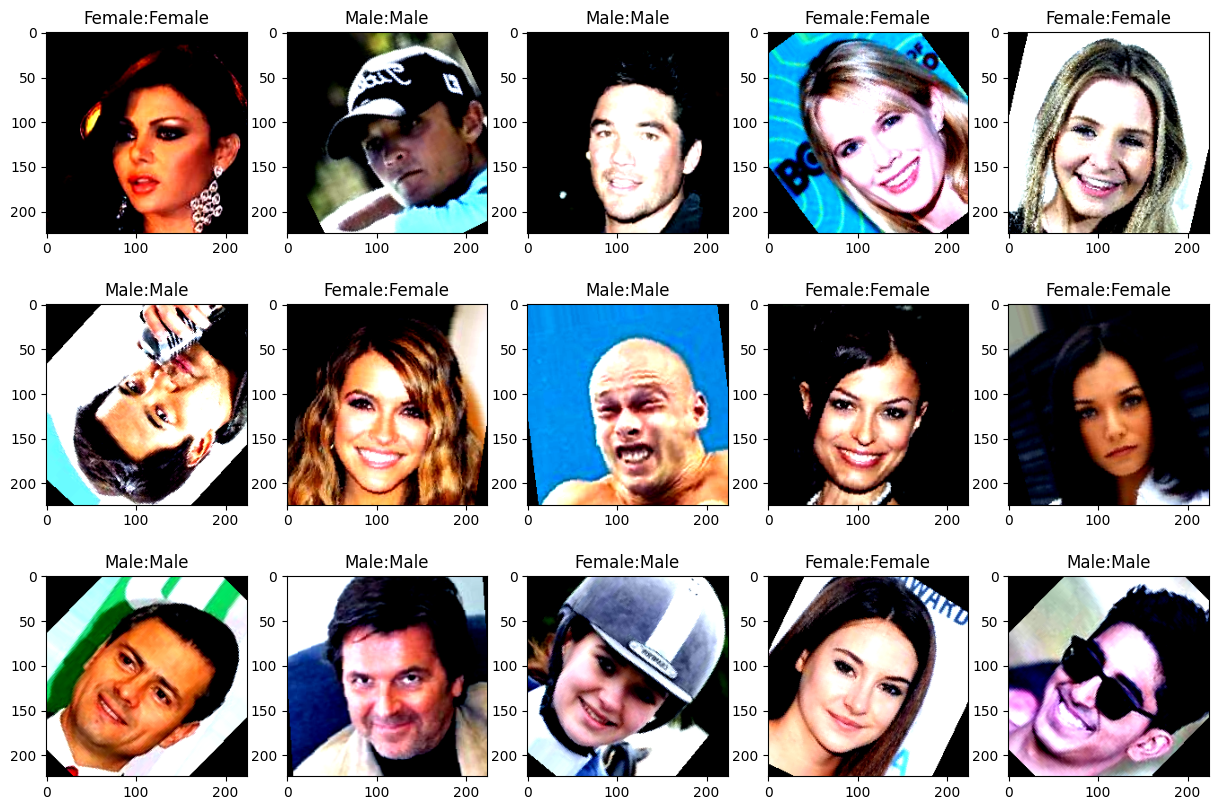

In [ ]:
dataiter = iter(dataloders['test'])
images, labels = next(dataiter)
classes = {0: 'Female', 1: 'Male'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor = image_tensor.cuda()
        output_ = model(image_tensor)
        output_ = output_.argmax()
        ax.set_title(str(classes[label.item()])+":" +str(classes[output_.item()])) # add label